In [1]:
# This script provides a minimal, educational implementation of the Diffusion Transformer (DiT)
# model, as introduced in the paper "Scalable Diffusion Models with Transformers" by
# William Peebles and Saining Xie (https://arxiv.org/abs/2212.09748).
#
# This implementation is intended for educational purposes to demystify the DiT architecture.
# It is not an official implementation from the paper's authors.

import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from dataclasses import dataclass

@dataclass
class DiTConfig:
    image_size: int = 256
    patch_size: int = 16
    in_channels: int = 3
    n_embd: int = 768
    n_head: int = 12
    n_layer: int = 12
    dropout: float = 0.1

    @property
    def n_ctx(self):
        return (self.image_size // self.patch_size) ** 2

class SelfAttention(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p, is_causal=False)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class DiTBlock(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        self.norm1 = nn.LayerNorm(config.n_embd, elementwise_affine=False, eps=1e-6)
        self.attn = SelfAttention(config)
        self.norm2 = nn.LayerNorm(config.n_embd, elementwise_affine=False, eps=1e-6)
        self.mlp = FeedForward(config)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(config.n_embd, 6 * config.n_embd, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x

class FinalLayer(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        self.norm_final = nn.LayerNorm(config.n_embd, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(config.n_embd, config.patch_size * config.patch_size * config.in_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(config.n_embd, 2 * config.n_embd, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        return self.mlp(t_freq)

class DiT(nn.Module):
    def __init__(self, config: DiTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.in_channels = config.in_channels
        self.out_channels = config.in_channels
        self.patch_size = config.patch_size
        self.num_heads = config.n_head

        self.x_embedder = nn.Conv2d(self.in_channels, config.n_embd, kernel_size=self.patch_size, stride=self.patch_size)
        self.t_embedder = TimestepEmbedder(config.n_embd)
        self.y_embedder = nn.Embedding(num_classes, config.n_embd)

        self.pos_embed = nn.Parameter(torch.zeros(1, config.n_ctx, config.n_embd))

        self.blocks = nn.ModuleList([
            DiTBlock(config) for _ in range(config.n_layer)
        ])
        self.final_layer = FinalLayer(config)
        self.initialize_weights()

    def initialize_weights(self):
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        nn.init.normal_(self.pos_embed, std=0.02)

        nn.init.normal_(self.y_embedder.weight, std=0.02)

        nn.init.kaiming_normal_(self.x_embedder.weight, mode="fan_in", nonlinearity="relu")

        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)

    def unpatchify(self, x):
        c = self.out_channels
        p = self.patch_size
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
        return imgs

    def forward(self, x, t, y):
        x = self.x_embedder(x).flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        t = self.t_embedder(t)
        y = self.y_embedder(y)
        c = t + y

        for block in self.blocks:
            x = block(x, c)

        x = self.final_layer(x, c)
        x = self.unpatchify(x)
        return x

Loading dataset from Hugging Face...
Loading dataset 'conceptual_captions' in streaming mode...


README.md: 0.00B [00:00, ?B/s]

Filtering for 8000 valid image samples...


Filtering samples: 11481it [1:41:20,  1.89it/s]                           


Successfully loaded and filtered 8000 images.
Dataset split: 7200 training samples, 800 validation samples.
Initializing DiT model on cuda...
Compiling model with torch.compile()...
Starting training...


Epoch 1/100:   0%|          | 0/225 [00:00<?, ?it/s]W0717 15:02:43.993000 36 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /tmp/ipykernel_36/3147336823.py line 181 
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233] due to: 
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0717 15:02:45.734000 36 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0717 15:02:45.734000 36

Epoch 1 Validation Loss: 1.0051
Epoch 1: Generating sample image...


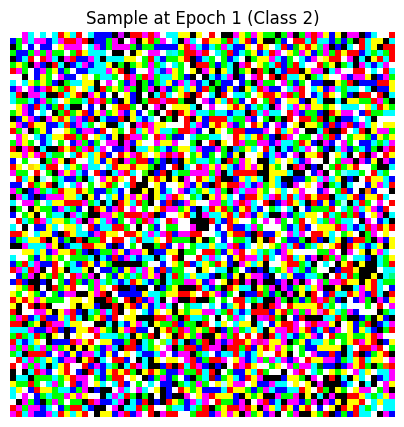

Epoch 2/100: 100%|██████████| 225/225 [00:15<00:00, 14.78it/s, train_loss=1]    


Epoch 2 Validation Loss: 0.9988
Epoch 2: Generating sample image...


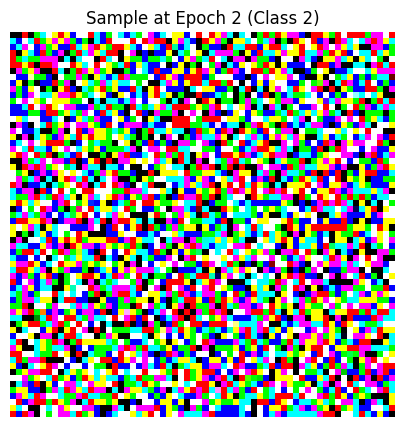

Epoch 3/100: 100%|██████████| 225/225 [00:15<00:00, 14.72it/s, train_loss=1]    


Epoch 3 Validation Loss: 0.9986
Epoch 3: Generating sample image...


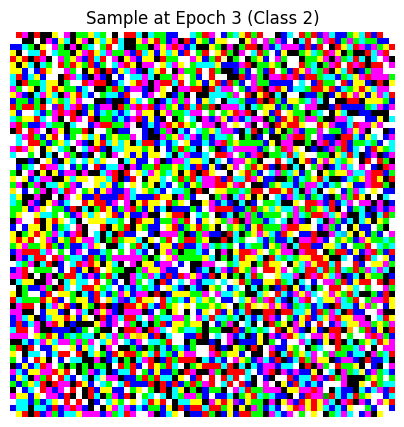

Epoch 4/100: 100%|██████████| 225/225 [00:15<00:00, 14.41it/s, train_loss=0.994]


Epoch 4 Validation Loss: 0.9967
Epoch 4: Generating sample image...


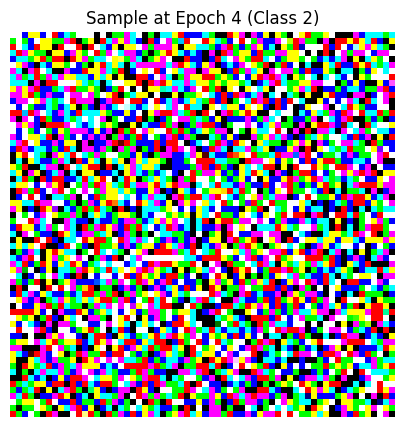

Epoch 5/100: 100%|██████████| 225/225 [00:15<00:00, 14.48it/s, train_loss=0.988]


Epoch 5 Validation Loss: 0.9883
Epoch 5: Generating sample image...


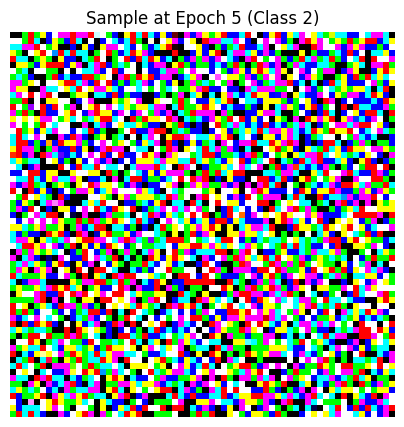

Epoch 6/100: 100%|██████████| 225/225 [00:15<00:00, 14.67it/s, train_loss=0.984]


Epoch 6 Validation Loss: 0.9820
Epoch 6: Generating sample image...


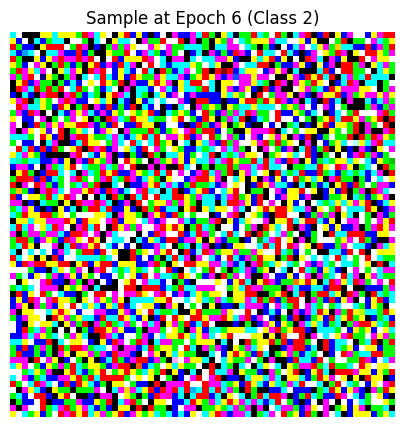

Epoch 7/100: 100%|██████████| 225/225 [00:15<00:00, 14.93it/s, train_loss=0.972]


Epoch 7 Validation Loss: 0.9687
Epoch 7: Generating sample image...


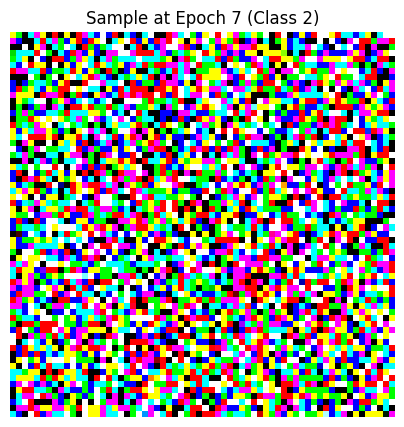

Epoch 8/100: 100%|██████████| 225/225 [00:15<00:00, 14.52it/s, train_loss=1.02]


Epoch 8 Validation Loss: 1.0040
Epoch 8: Generating sample image...


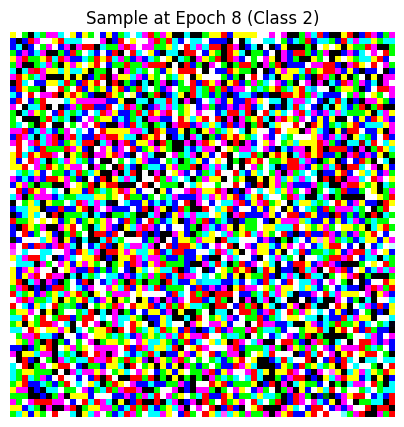

Epoch 9/100: 100%|██████████| 225/225 [00:15<00:00, 14.65it/s, train_loss=1.01]


Epoch 9 Validation Loss: 1.0017
Epoch 9: Generating sample image...


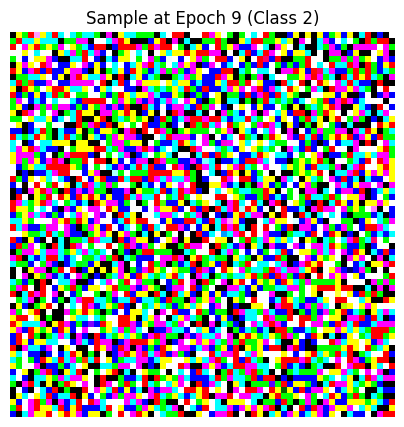

Epoch 10/100: 100%|██████████| 225/225 [00:15<00:00, 14.78it/s, train_loss=1.01]


Epoch 10 Validation Loss: 1.0016
Epoch 10: Generating sample image...


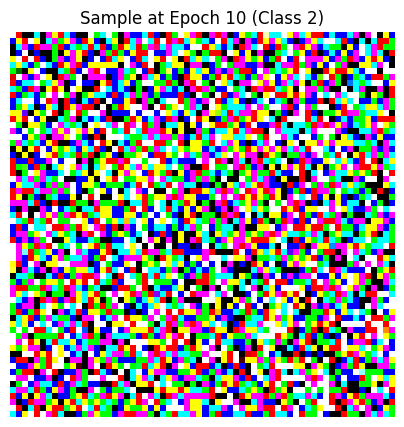

Epoch 11/100: 100%|██████████| 225/225 [00:15<00:00, 14.84it/s, train_loss=1.01]


Epoch 11 Validation Loss: 1.0002
Epoch 11: Generating sample image...


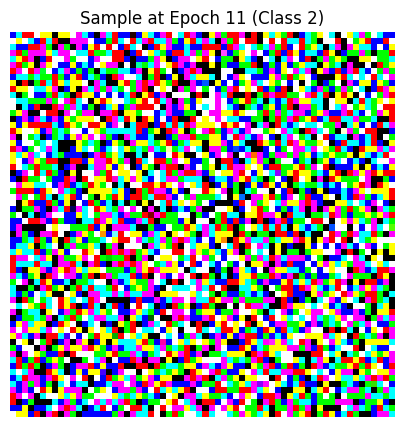

Epoch 12/100: 100%|██████████| 225/225 [00:15<00:00, 14.49it/s, train_loss=1]   


Epoch 12 Validation Loss: 1.0007
Epoch 12: Generating sample image...


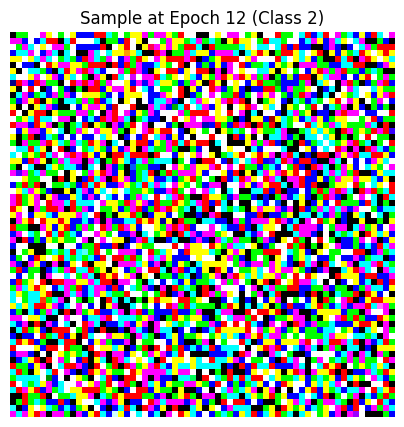

Epoch 13/100: 100%|██████████| 225/225 [00:15<00:00, 14.57it/s, train_loss=1.01] 


Epoch 13 Validation Loss: 1.0004
Epoch 13: Generating sample image...


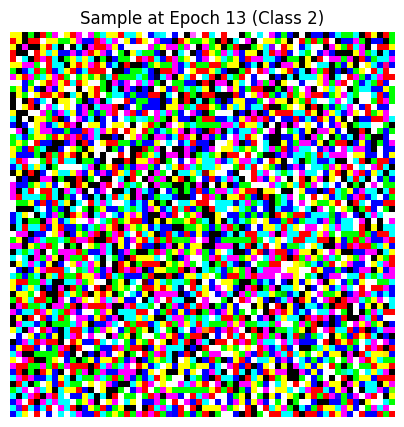

Epoch 14/100: 100%|██████████| 225/225 [00:15<00:00, 14.76it/s, train_loss=1.01] 


Epoch 14 Validation Loss: 0.9998
Epoch 14: Generating sample image...


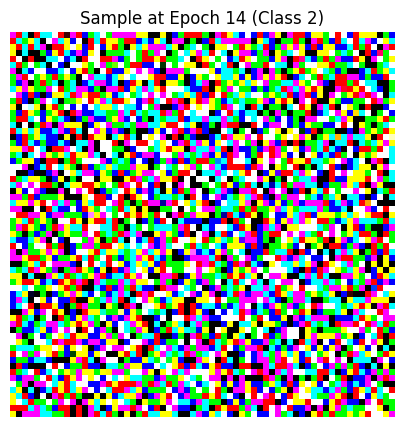

Epoch 15/100: 100%|██████████| 225/225 [00:15<00:00, 14.72it/s, train_loss=1]    


Epoch 15 Validation Loss: 1.0002
Epoch 15: Generating sample image...


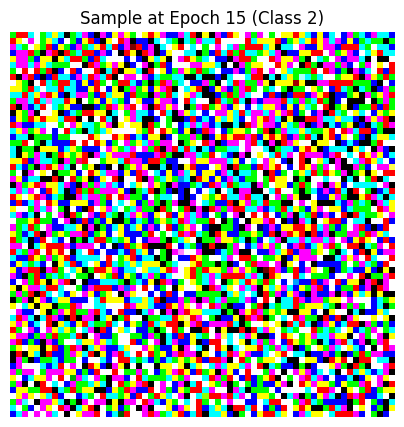

Epoch 16/100: 100%|██████████| 225/225 [00:15<00:00, 14.57it/s, train_loss=1]    


Epoch 16 Validation Loss: 1.0008
Epoch 16: Generating sample image...


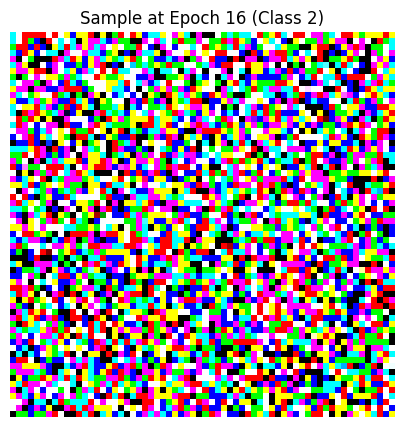

Epoch 17/100: 100%|██████████| 225/225 [00:15<00:00, 14.65it/s, train_loss=1]    


Epoch 17 Validation Loss: 1.0004
Epoch 17: Generating sample image...


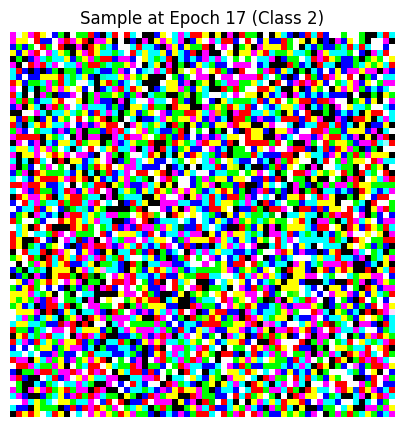

Epoch 18/100: 100%|██████████| 225/225 [00:15<00:00, 14.87it/s, train_loss=1.01] 


Epoch 18 Validation Loss: 1.0005
Epoch 18: Generating sample image...


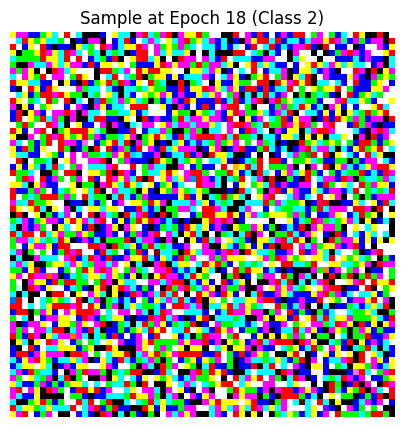

Epoch 19/100: 100%|██████████| 225/225 [00:15<00:00, 14.69it/s, train_loss=1]    


Epoch 19 Validation Loss: 1.0008
Epoch 19: Generating sample image...


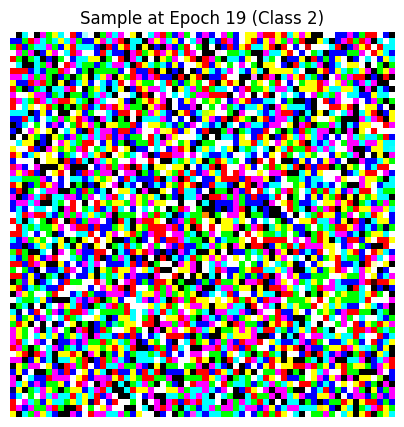

Epoch 20/100: 100%|██████████| 225/225 [00:15<00:00, 14.37it/s, train_loss=0.998]


Epoch 20 Validation Loss: 1.0003
Epoch 20: Generating sample image...


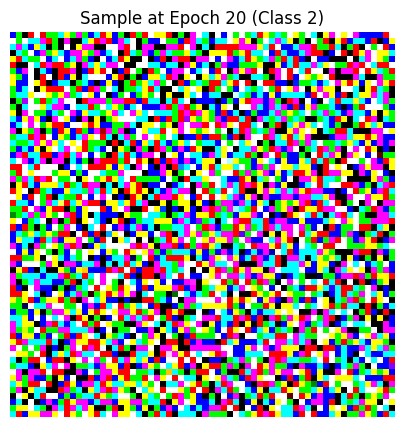

Epoch 21/100: 100%|██████████| 225/225 [00:15<00:00, 14.80it/s, train_loss=1]    


Epoch 21 Validation Loss: 1.0011
Epoch 21: Generating sample image...


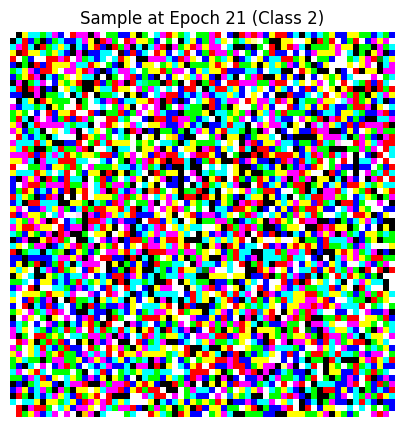

Epoch 22/100: 100%|██████████| 225/225 [00:15<00:00, 14.83it/s, train_loss=1]    


Epoch 22 Validation Loss: 0.9999
Epoch 22: Generating sample image...


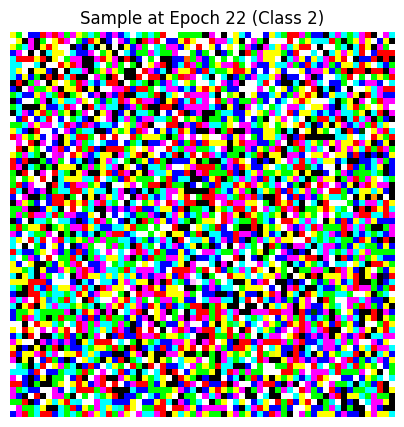

Epoch 23/100: 100%|██████████| 225/225 [00:15<00:00, 14.50it/s, train_loss=1]    


Epoch 23 Validation Loss: 1.0015
Epoch 23: Generating sample image...


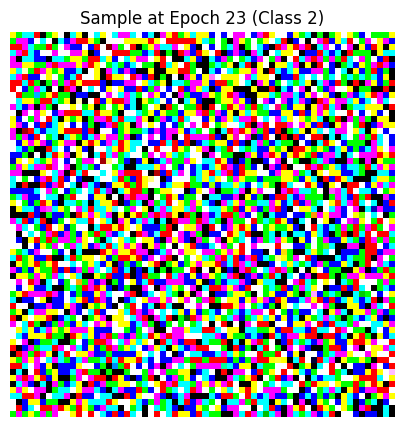

Epoch 24/100: 100%|██████████| 225/225 [00:15<00:00, 14.57it/s, train_loss=0.997]


Epoch 24 Validation Loss: 0.9996
Epoch 24: Generating sample image...


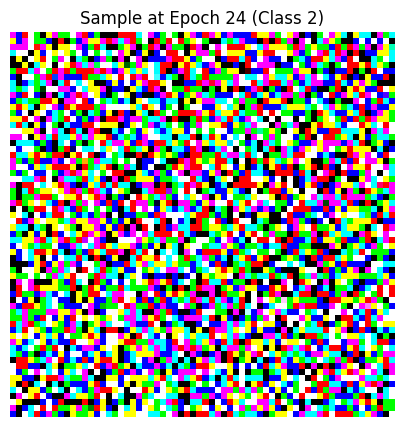

Epoch 25/100: 100%|██████████| 225/225 [00:15<00:00, 14.70it/s, train_loss=0.999]


Epoch 25 Validation Loss: 0.9998
Epoch 25: Generating sample image...


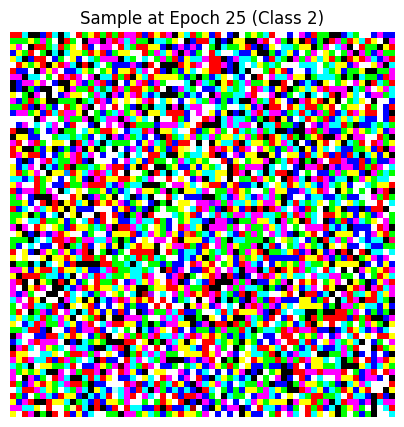

Epoch 26/100: 100%|██████████| 225/225 [00:15<00:00, 14.98it/s, train_loss=0.996]


Epoch 26 Validation Loss: 1.0004
Epoch 26: Generating sample image...


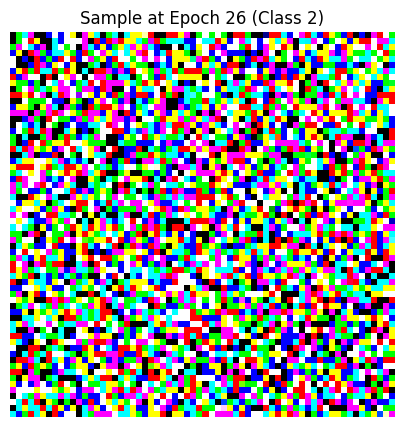

Epoch 27/100: 100%|██████████| 225/225 [00:15<00:00, 14.57it/s, train_loss=1]    


Epoch 27 Validation Loss: 1.0003
Epoch 27: Generating sample image...


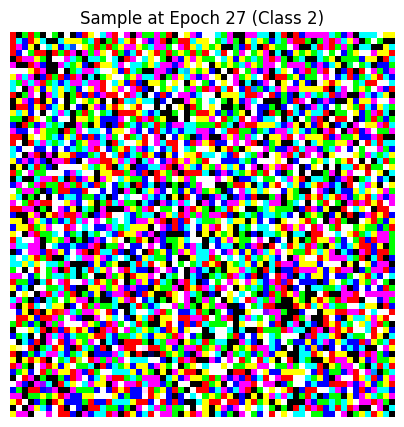

Epoch 28/100: 100%|██████████| 225/225 [00:15<00:00, 14.56it/s, train_loss=1]    


Epoch 28 Validation Loss: 0.9995
Epoch 28: Generating sample image...


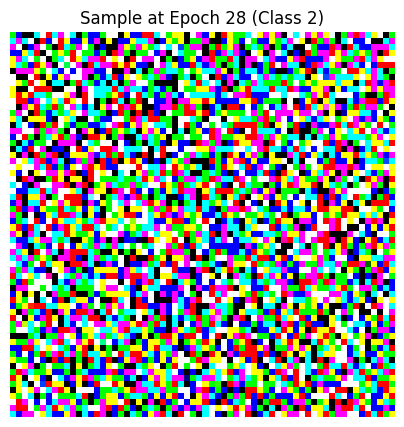

Epoch 29/100: 100%|██████████| 225/225 [00:15<00:00, 14.90it/s, train_loss=1]    


Epoch 29 Validation Loss: 1.0001
Epoch 29: Generating sample image...


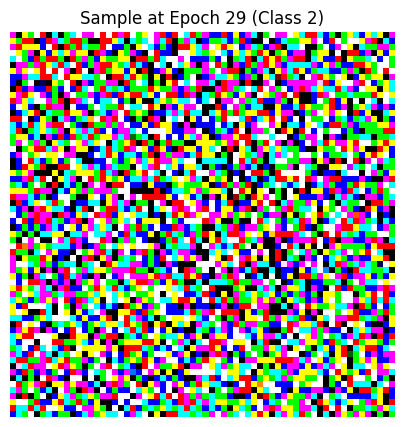

Epoch 30/100: 100%|██████████| 225/225 [00:15<00:00, 14.92it/s, train_loss=0.999]


Epoch 30 Validation Loss: 1.0000
Epoch 30: Generating sample image...


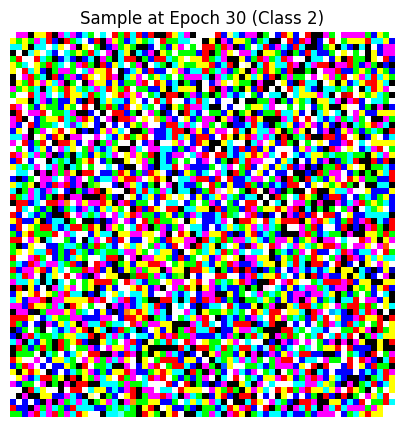

Epoch 31/100: 100%|██████████| 225/225 [00:15<00:00, 14.60it/s, train_loss=1]    


Epoch 31 Validation Loss: 1.0009
Epoch 31: Generating sample image...


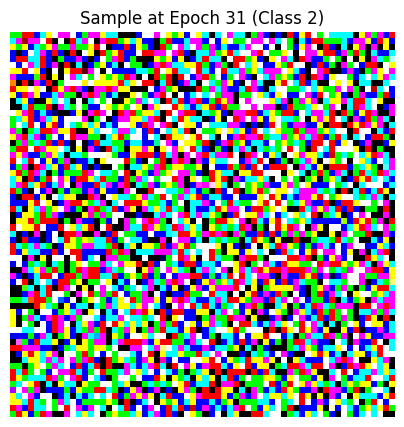

Epoch 32/100: 100%|██████████| 225/225 [00:15<00:00, 14.79it/s, train_loss=1]    


Epoch 32 Validation Loss: 1.0019
Epoch 32: Generating sample image...


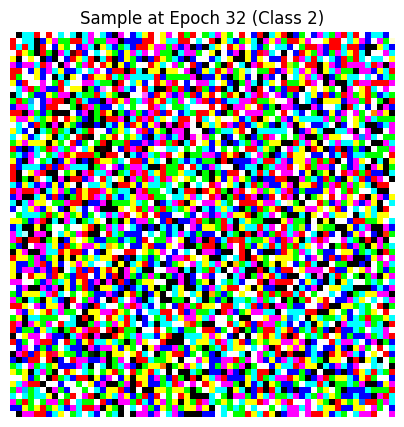

Epoch 33/100: 100%|██████████| 225/225 [00:15<00:00, 14.83it/s, train_loss=1.01] 


Epoch 33 Validation Loss: 1.0003
Epoch 33: Generating sample image...


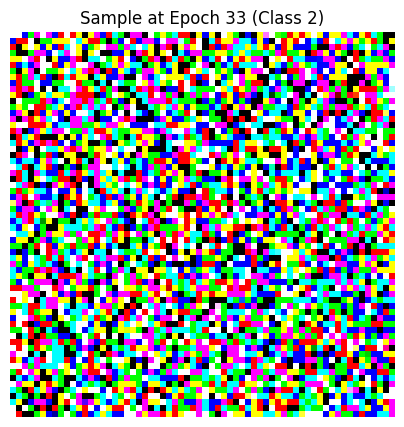

Epoch 34/100: 100%|██████████| 225/225 [00:15<00:00, 14.77it/s, train_loss=1]    


Epoch 34 Validation Loss: 1.0009
Epoch 34: Generating sample image...


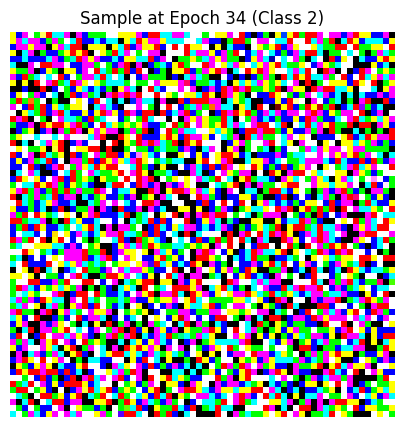

Epoch 35/100: 100%|██████████| 225/225 [00:15<00:00, 14.49it/s, train_loss=1]    


Epoch 35 Validation Loss: 1.0000
Epoch 35: Generating sample image...


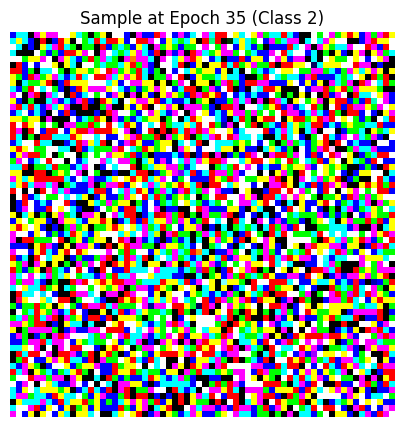

Epoch 36/100: 100%|██████████| 225/225 [00:15<00:00, 14.66it/s, train_loss=0.999]


Epoch 36 Validation Loss: 0.9991
Epoch 36: Generating sample image...


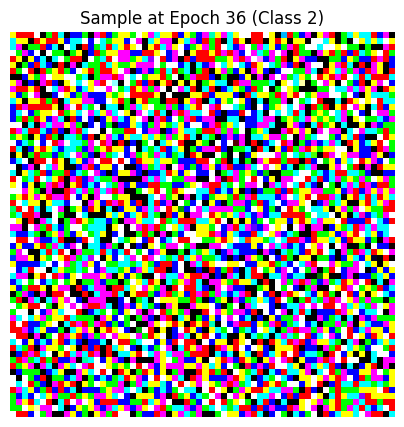

Epoch 37/100: 100%|██████████| 225/225 [00:14<00:00, 15.04it/s, train_loss=0.998]


Epoch 37 Validation Loss: 0.9976
Epoch 37: Generating sample image...


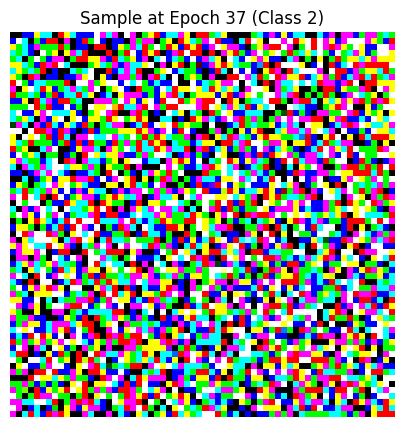

Epoch 38/100: 100%|██████████| 225/225 [00:14<00:00, 15.05it/s, train_loss=0.998]


Epoch 38 Validation Loss: 0.9969
Epoch 38: Generating sample image...


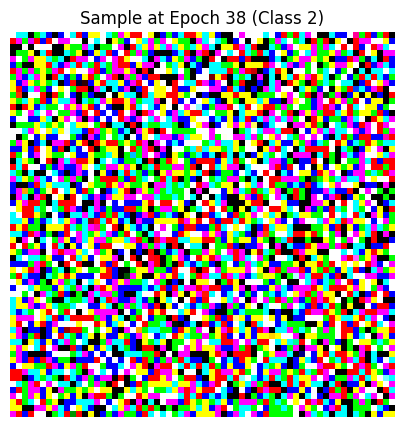

Epoch 39/100: 100%|██████████| 225/225 [00:15<00:00, 14.77it/s, train_loss=0.997]


Epoch 39 Validation Loss: 0.9962
Epoch 39: Generating sample image...


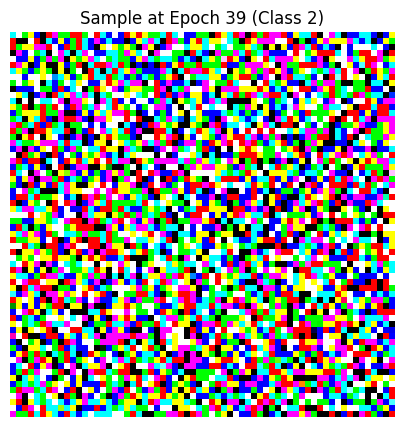

Epoch 40/100: 100%|██████████| 225/225 [00:14<00:00, 15.06it/s, train_loss=0.995]


Epoch 40 Validation Loss: 0.9924
Epoch 40: Generating sample image...


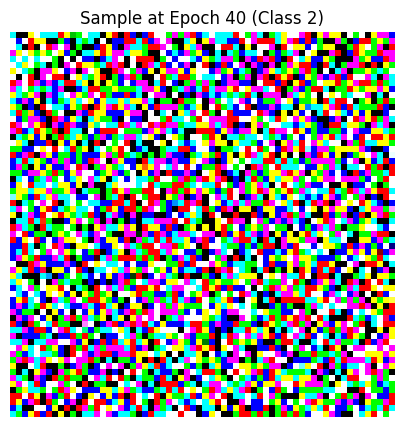

Epoch 41/100: 100%|██████████| 225/225 [00:14<00:00, 15.04it/s, train_loss=0.991]


Epoch 41 Validation Loss: 0.9909
Epoch 41: Generating sample image...


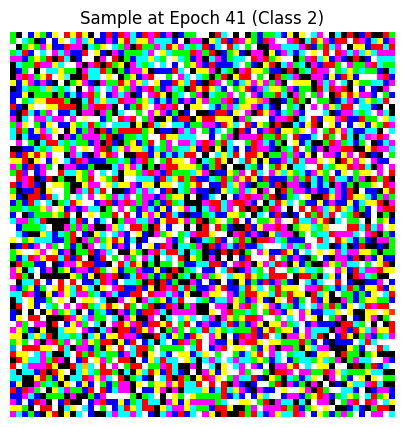

Epoch 42/100: 100%|██████████| 225/225 [00:15<00:00, 14.74it/s, train_loss=0.989]


Epoch 42 Validation Loss: 0.9884
Epoch 42: Generating sample image...


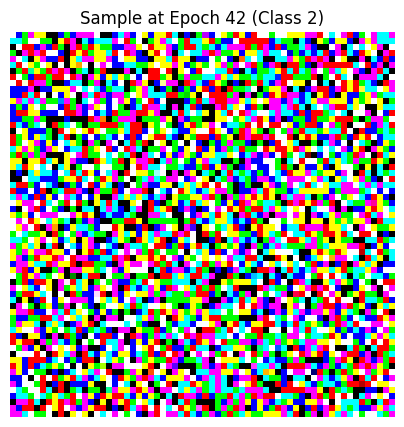

Epoch 43/100: 100%|██████████| 225/225 [00:15<00:00, 14.73it/s, train_loss=0.987]


Epoch 43 Validation Loss: 0.9847
Epoch 43: Generating sample image...


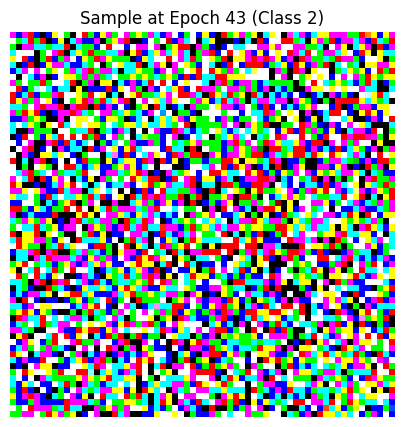

Epoch 44/100: 100%|██████████| 225/225 [00:14<00:00, 15.03it/s, train_loss=0.975]


Epoch 44 Validation Loss: 0.9759
Epoch 44: Generating sample image...


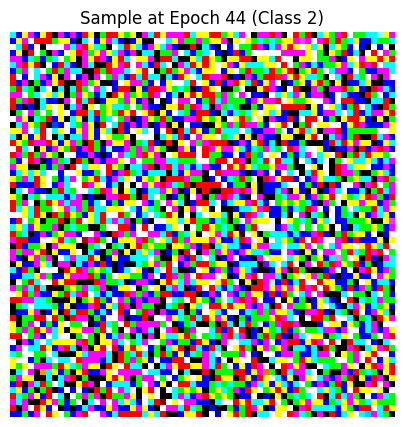

Epoch 45/100: 100%|██████████| 225/225 [00:14<00:00, 15.14it/s, train_loss=0.967]


Epoch 45 Validation Loss: 0.9658
Epoch 45: Generating sample image...


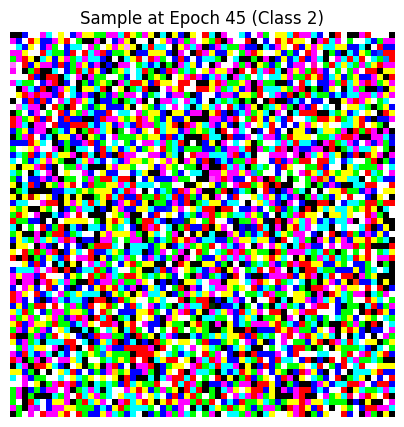

Epoch 46/100: 100%|██████████| 225/225 [00:15<00:00, 14.69it/s, train_loss=0.953]


Epoch 46 Validation Loss: 0.9503
Epoch 46: Generating sample image...


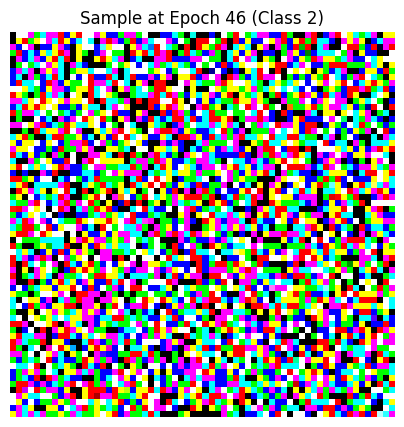

Epoch 47/100: 100%|██████████| 225/225 [00:15<00:00, 14.91it/s, train_loss=0.939]


Epoch 47 Validation Loss: 0.9375
Epoch 47: Generating sample image...


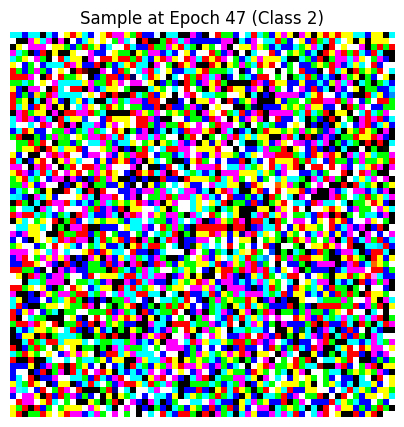

Epoch 48/100: 100%|██████████| 225/225 [00:14<00:00, 15.09it/s, train_loss=0.956]


Epoch 48 Validation Loss: 0.9980
Epoch 48: Generating sample image...


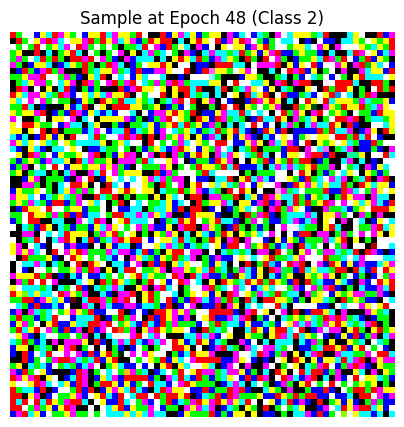

Epoch 49/100: 100%|██████████| 225/225 [00:15<00:00, 14.81it/s, train_loss=0.992]


Epoch 49 Validation Loss: 0.9901
Epoch 49: Generating sample image...


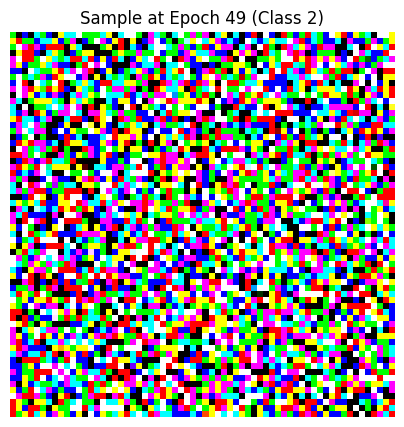

Epoch 50/100: 100%|██████████| 225/225 [00:15<00:00, 14.81it/s, train_loss=0.982]


Epoch 50 Validation Loss: 0.9727
Epoch 50: Generating sample image...


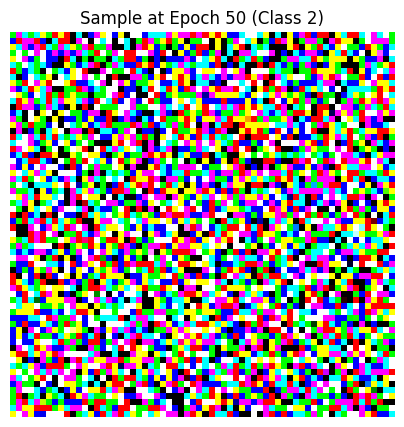

Epoch 51/100: 100%|██████████| 225/225 [00:15<00:00, 15.00it/s, train_loss=0.957]


Epoch 51 Validation Loss: 0.9544
Epoch 51: Generating sample image...


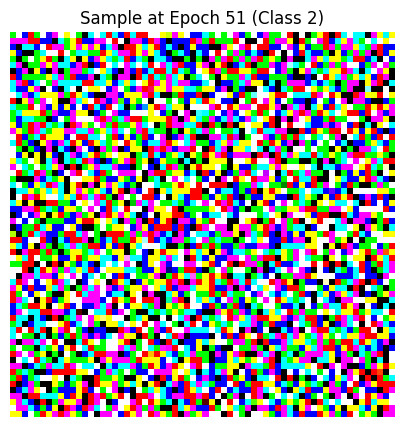

Epoch 52/100: 100%|██████████| 225/225 [00:14<00:00, 15.11it/s, train_loss=0.944]


Epoch 52 Validation Loss: 0.9402
Epoch 52: Generating sample image...


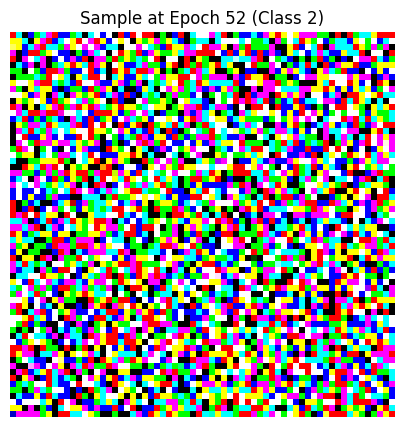

Epoch 53/100: 100%|██████████| 225/225 [00:15<00:00, 14.76it/s, train_loss=0.936]


Epoch 53 Validation Loss: 0.9333
Epoch 53: Generating sample image...


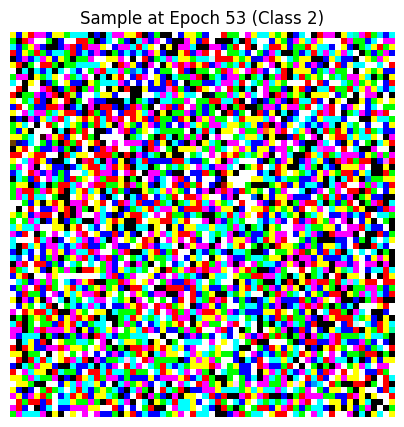

Epoch 54/100: 100%|██████████| 225/225 [00:15<00:00, 14.87it/s, train_loss=0.93] 


Epoch 54 Validation Loss: 0.9315
Epoch 54: Generating sample image...


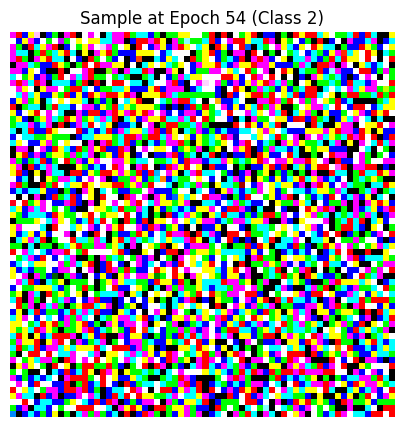

Epoch 55/100: 100%|██████████| 225/225 [00:14<00:00, 15.10it/s, train_loss=0.928]


Epoch 55 Validation Loss: 0.9273
Epoch 55: Generating sample image...


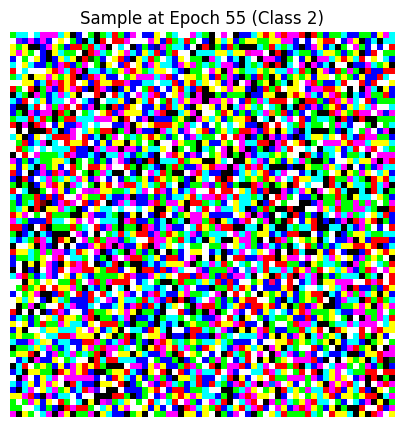

Epoch 56/100: 100%|██████████| 225/225 [00:14<00:00, 15.02it/s, train_loss=0.936]


Epoch 56 Validation Loss: 0.9238
Epoch 56: Generating sample image...


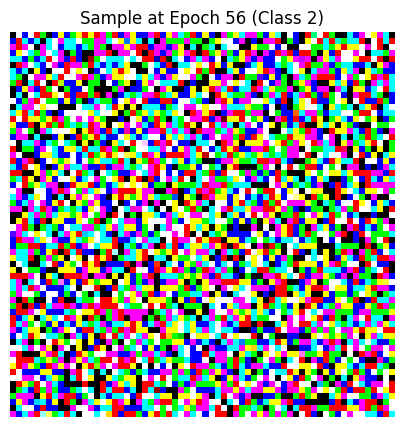

Epoch 57/100: 100%|██████████| 225/225 [00:15<00:00, 14.67it/s, train_loss=0.922]


Epoch 57 Validation Loss: 0.9199
Epoch 57: Generating sample image...


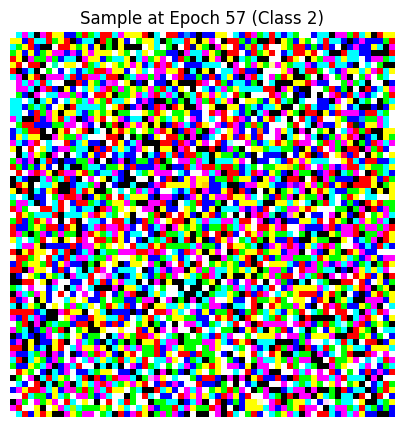

Epoch 58/100: 100%|██████████| 225/225 [00:14<00:00, 15.10it/s, train_loss=0.92] 


Epoch 58 Validation Loss: 0.9141
Epoch 58: Generating sample image...


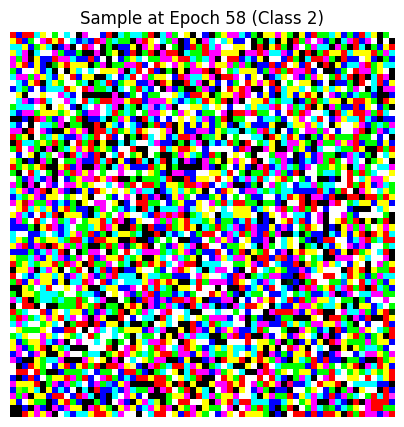

Epoch 59/100: 100%|██████████| 225/225 [00:15<00:00, 14.95it/s, train_loss=0.893]


Epoch 59 Validation Loss: 0.8851
Epoch 59: Generating sample image...


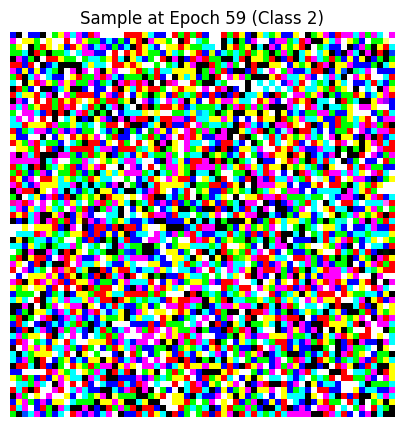

Epoch 60/100: 100%|██████████| 225/225 [00:15<00:00, 14.38it/s, train_loss=0.822]


Epoch 60 Validation Loss: 0.8125
Epoch 60: Generating sample image...


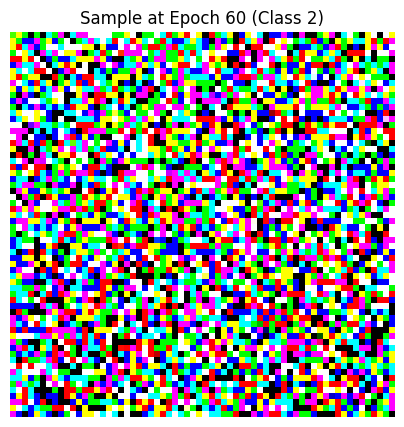

Epoch 61/100: 100%|██████████| 225/225 [00:15<00:00, 14.70it/s, train_loss=0.734]


Epoch 61 Validation Loss: 0.7099
Epoch 61: Generating sample image...


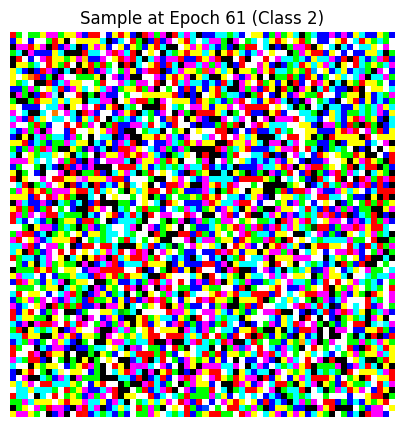

Epoch 62/100: 100%|██████████| 225/225 [00:14<00:00, 15.06it/s, train_loss=0.458]


Epoch 62 Validation Loss: 0.4075
Epoch 62: Generating sample image...


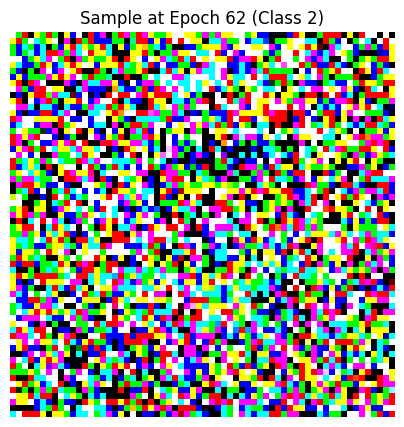

Epoch 63/100: 100%|██████████| 225/225 [00:15<00:00, 14.88it/s, train_loss=0.0411]


Epoch 63 Validation Loss: 0.1000
Epoch 63: Generating sample image...


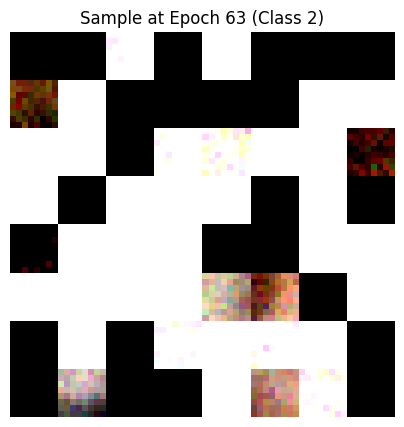

Epoch 64/100: 100%|██████████| 225/225 [00:15<00:00, 14.72it/s, train_loss=0.0897]


Epoch 64 Validation Loss: 0.0623
Epoch 64: Generating sample image...


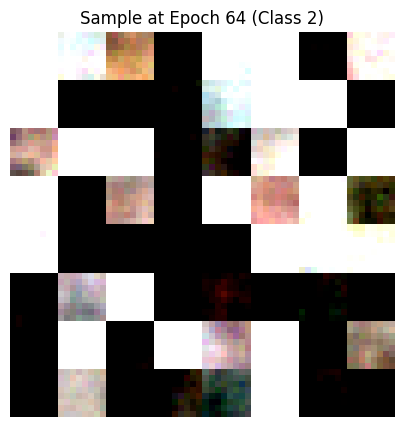

Epoch 65/100: 100%|██████████| 225/225 [00:15<00:00, 14.65it/s, train_loss=0.0368]


Epoch 65 Validation Loss: 0.0660
Epoch 65: Generating sample image...


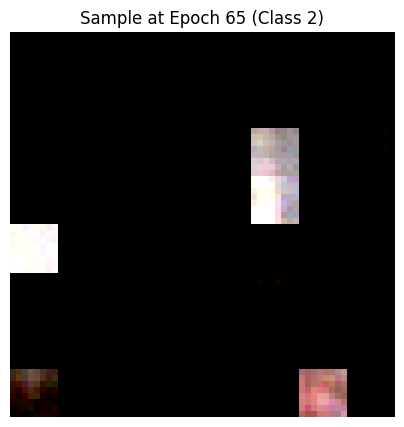

Epoch 66/100: 100%|██████████| 225/225 [00:14<00:00, 15.13it/s, train_loss=0.0922]


Epoch 66 Validation Loss: 0.0614
Epoch 66: Generating sample image...


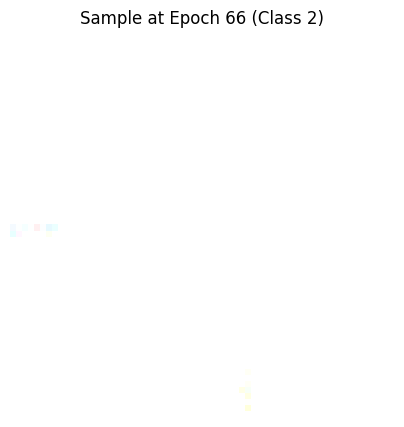

Epoch 67/100: 100%|██████████| 225/225 [00:15<00:00, 14.97it/s, train_loss=0.0633]


Epoch 67 Validation Loss: 0.0591
Epoch 67: Generating sample image...


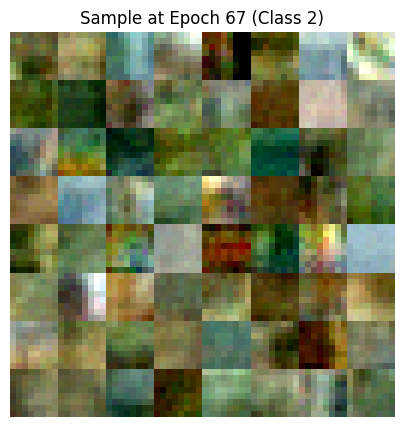

Epoch 68/100: 100%|██████████| 225/225 [00:15<00:00, 14.65it/s, train_loss=0.0465]


Epoch 68 Validation Loss: 0.0628
Epoch 68: Generating sample image...


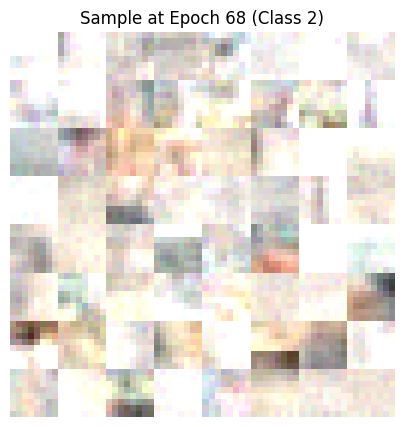

Epoch 69/100: 100%|██████████| 225/225 [00:15<00:00, 14.48it/s, train_loss=0.0481]


Epoch 69 Validation Loss: 0.0532
Epoch 69: Generating sample image...


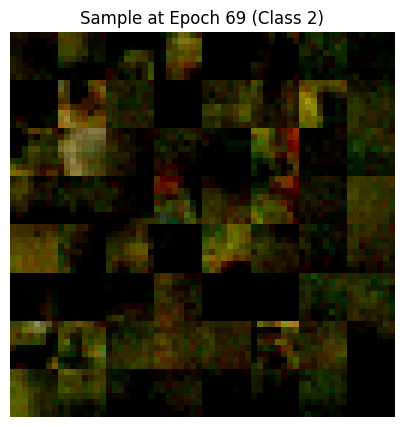

Epoch 70/100: 100%|██████████| 225/225 [00:15<00:00, 14.93it/s, train_loss=0.0775]


Epoch 70 Validation Loss: 0.0551
Epoch 70: Generating sample image...


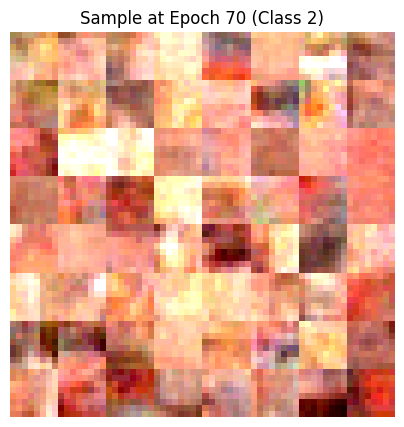

Epoch 71/100: 100%|██████████| 225/225 [00:14<00:00, 15.03it/s, train_loss=0.0588]


Epoch 71 Validation Loss: 0.0643
Epoch 71: Generating sample image...


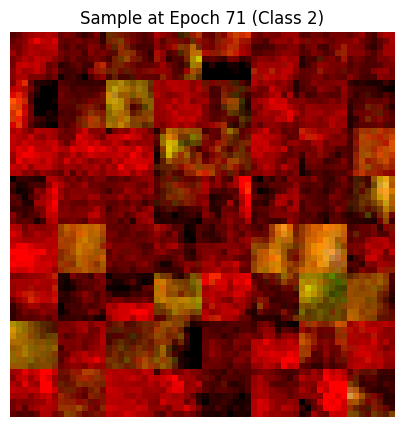

Epoch 72/100: 100%|██████████| 225/225 [00:15<00:00, 14.76it/s, train_loss=0.0416]


Epoch 72 Validation Loss: 0.0645
Epoch 72: Generating sample image...


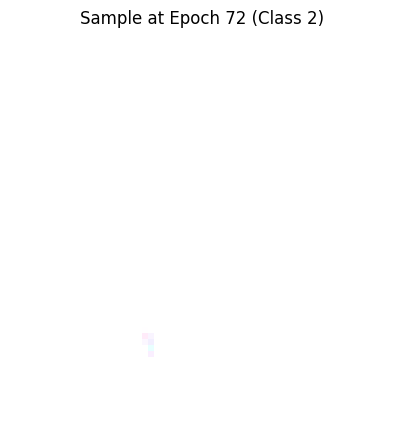

Epoch 73/100: 100%|██████████| 225/225 [00:15<00:00, 14.84it/s, train_loss=0.0476]


Epoch 73 Validation Loss: 0.0550
Epoch 73: Generating sample image...


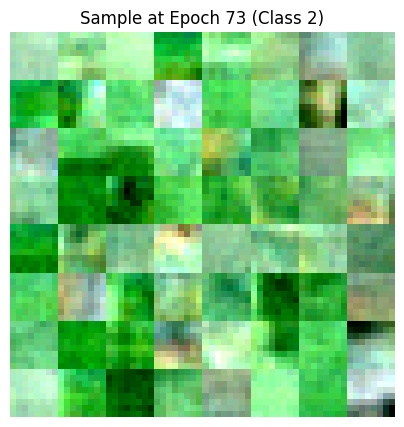

Epoch 74/100: 100%|██████████| 225/225 [00:15<00:00, 14.87it/s, train_loss=0.0347]


Epoch 74 Validation Loss: 0.0582
Epoch 74: Generating sample image...


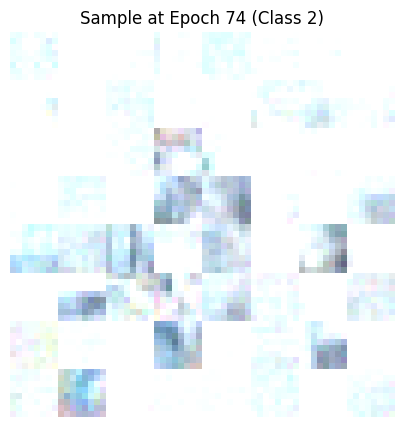

Epoch 75/100: 100%|██████████| 225/225 [00:15<00:00, 14.89it/s, train_loss=0.0629]


Epoch 75 Validation Loss: 0.0494
Epoch 75: Generating sample image...


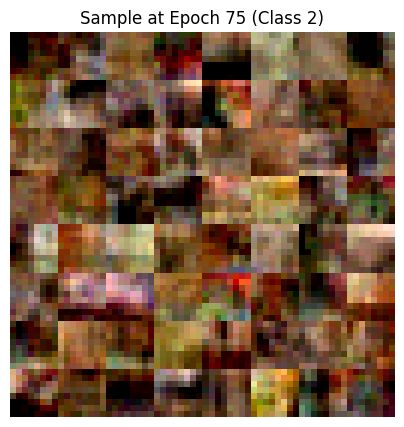

Epoch 76/100: 100%|██████████| 225/225 [00:15<00:00, 14.69it/s, train_loss=0.0424]


Epoch 76 Validation Loss: 0.0686
Epoch 76: Generating sample image...


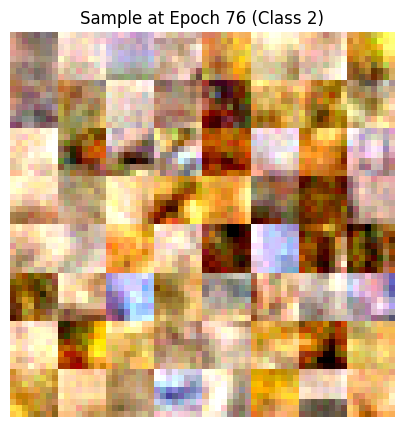

Epoch 77/100: 100%|██████████| 225/225 [00:14<00:00, 15.03it/s, train_loss=0.0835]


Epoch 77 Validation Loss: 0.0596
Epoch 77: Generating sample image...


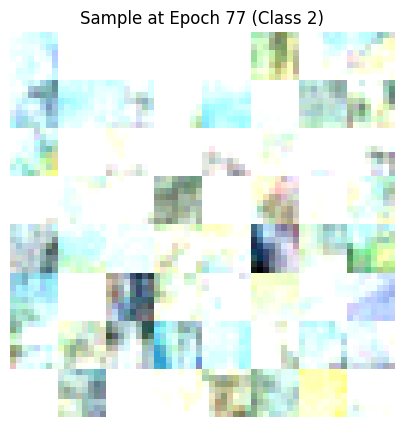

Epoch 78/100: 100%|██████████| 225/225 [00:14<00:00, 15.07it/s, train_loss=0.0323]


Epoch 78 Validation Loss: 0.0684
Epoch 78: Generating sample image...


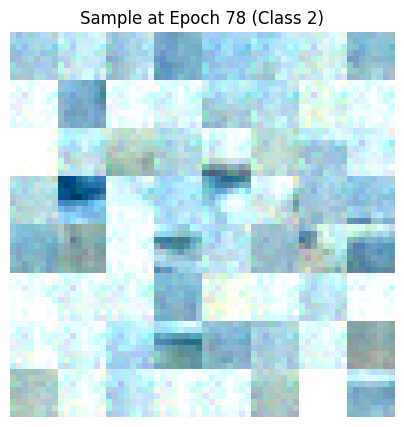

Epoch 79/100: 100%|██████████| 225/225 [00:15<00:00, 14.67it/s, train_loss=0.0966]


Epoch 79 Validation Loss: 0.0583
Epoch 79: Generating sample image...


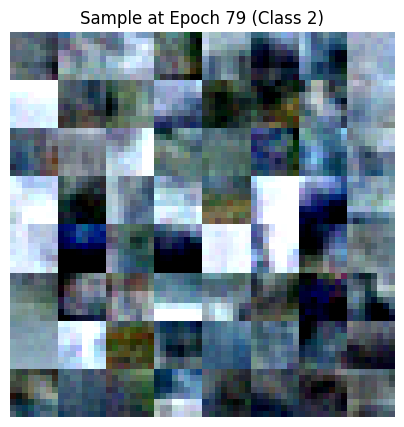

Epoch 80/100: 100%|██████████| 225/225 [00:15<00:00, 14.95it/s, train_loss=0.0487]


Epoch 80 Validation Loss: 0.0525
Epoch 80: Generating sample image...


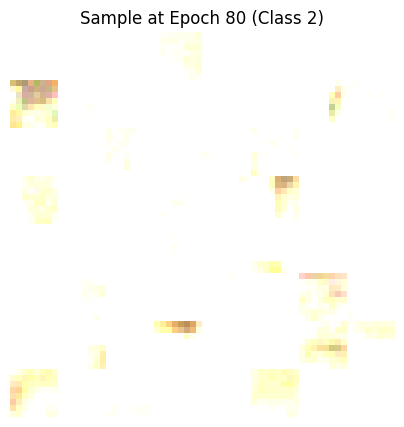

Epoch 81/100: 100%|██████████| 225/225 [00:15<00:00, 15.00it/s, train_loss=0.0566]


Epoch 81 Validation Loss: 0.0573
Epoch 81: Generating sample image...


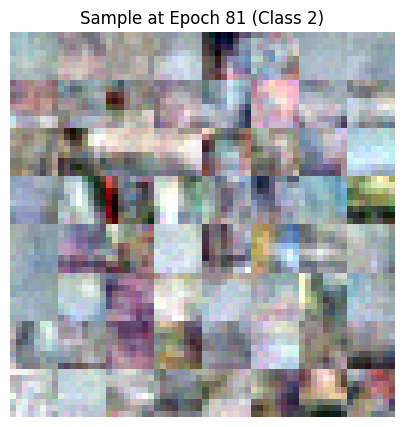

Epoch 82/100: 100%|██████████| 225/225 [00:14<00:00, 15.01it/s, train_loss=0.0544]


Epoch 82 Validation Loss: 0.0567
Epoch 82: Generating sample image...


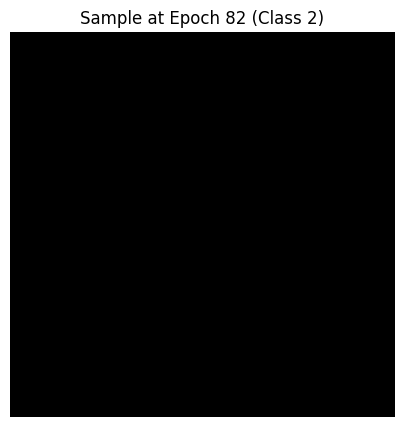

Epoch 83/100: 100%|██████████| 225/225 [00:15<00:00, 14.66it/s, train_loss=0.0626]


Epoch 83 Validation Loss: 0.0541
Epoch 83: Generating sample image...


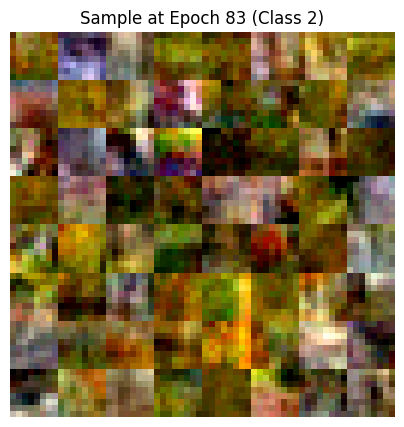

Epoch 84/100: 100%|██████████| 225/225 [00:15<00:00, 14.55it/s, train_loss=0.0336]


Epoch 84 Validation Loss: 0.0550
Epoch 84: Generating sample image...


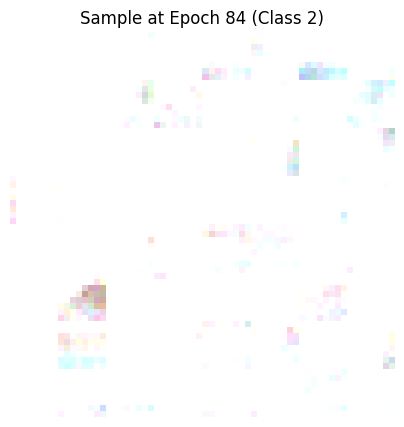

Epoch 85/100: 100%|██████████| 225/225 [00:14<00:00, 15.02it/s, train_loss=0.0605]


Epoch 85 Validation Loss: 0.0564
Epoch 85: Generating sample image...


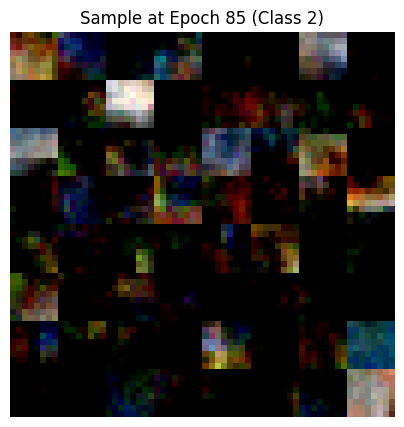

Epoch 86/100: 100%|██████████| 225/225 [00:15<00:00, 14.98it/s, train_loss=0.0535]


Epoch 86 Validation Loss: 0.0613
Epoch 86: Generating sample image...


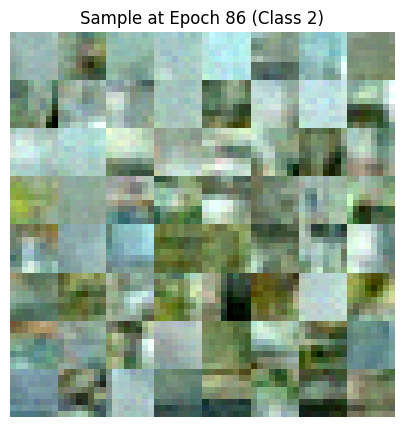

Epoch 87/100: 100%|██████████| 225/225 [00:15<00:00, 14.65it/s, train_loss=0.023] 


Epoch 87 Validation Loss: 0.0542
Epoch 87: Generating sample image...


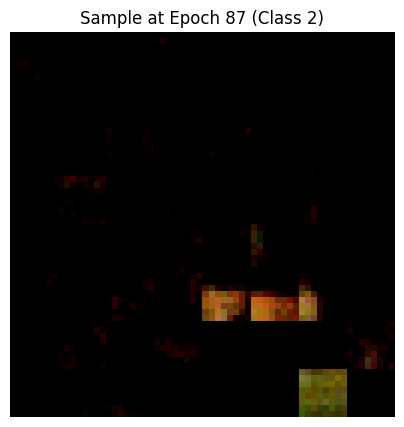

Epoch 88/100: 100%|██████████| 225/225 [00:14<00:00, 15.06it/s, train_loss=0.0612]


Epoch 88 Validation Loss: 0.0523
Epoch 88: Generating sample image...


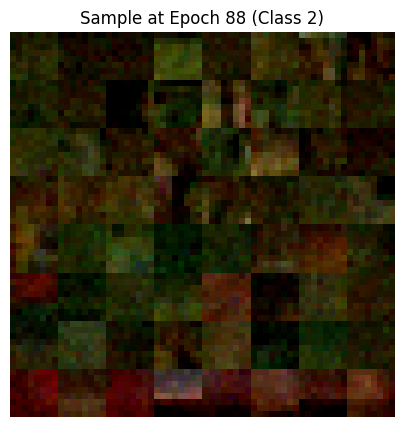

Epoch 89/100: 100%|██████████| 225/225 [00:15<00:00, 14.82it/s, train_loss=0.0314]


Epoch 89 Validation Loss: 0.0686
Epoch 89: Generating sample image...


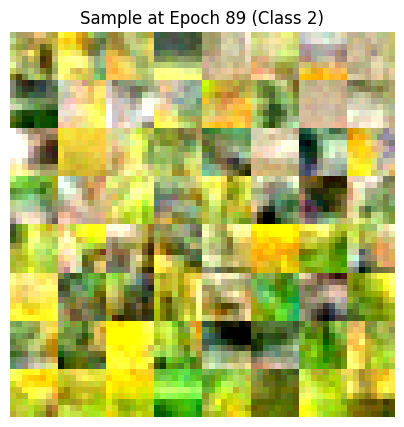

Epoch 90/100: 100%|██████████| 225/225 [00:15<00:00, 14.81it/s, train_loss=0.0802]


Epoch 90 Validation Loss: 0.0498
Epoch 90: Generating sample image...


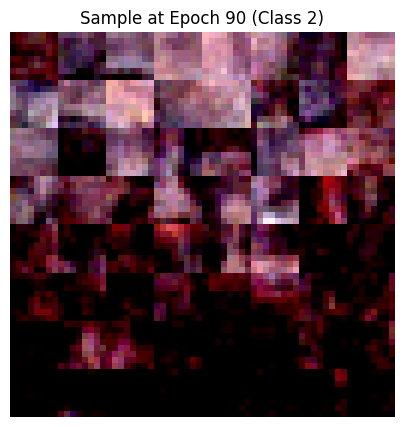

Epoch 91/100: 100%|██████████| 225/225 [00:15<00:00, 14.48it/s, train_loss=0.0735]


Epoch 91 Validation Loss: 0.0573
Epoch 91: Generating sample image...


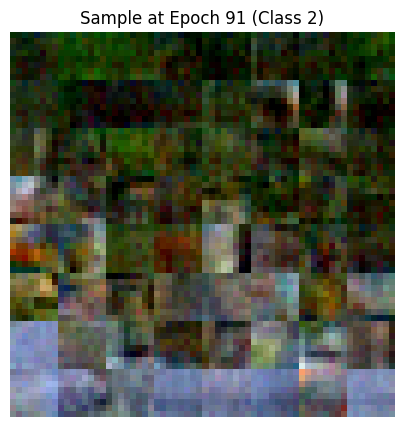

Epoch 92/100: 100%|██████████| 225/225 [00:14<00:00, 15.06it/s, train_loss=0.0387]


Epoch 92 Validation Loss: 0.0458
Epoch 92: Generating sample image...


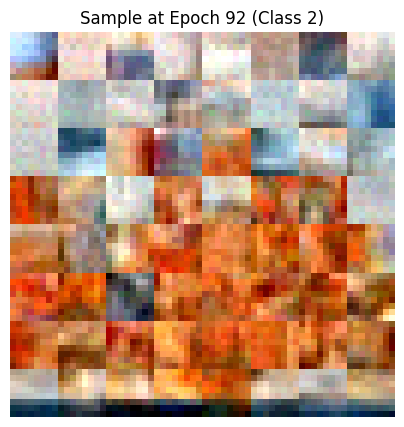

Epoch 93/100: 100%|██████████| 225/225 [00:15<00:00, 14.99it/s, train_loss=0.0774]


Epoch 93 Validation Loss: 0.0570
Epoch 93: Generating sample image...


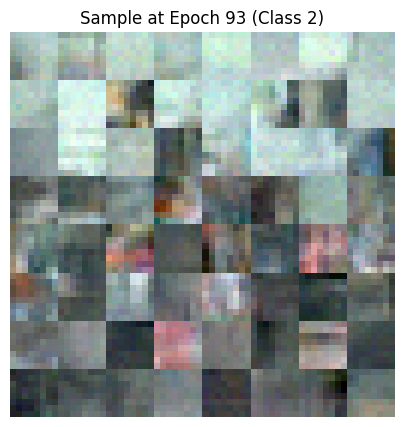

Epoch 94/100: 100%|██████████| 225/225 [00:15<00:00, 14.48it/s, train_loss=0.0623]


Epoch 94 Validation Loss: 0.0571
Epoch 94: Generating sample image...


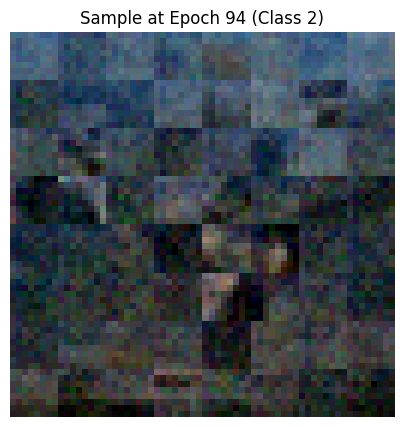

Epoch 95/100: 100%|██████████| 225/225 [00:15<00:00, 14.58it/s, train_loss=0.806]  


Epoch 95 Validation Loss: 0.7707
Epoch 95: Generating sample image...


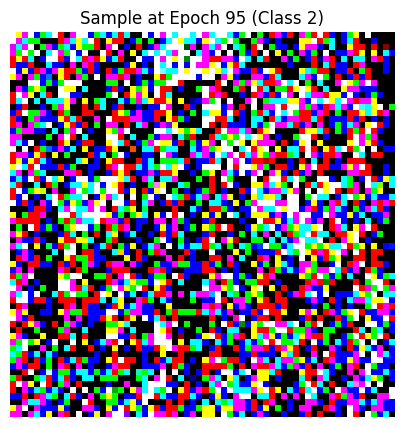

Epoch 96/100: 100%|██████████| 225/225 [00:15<00:00, 14.99it/s, train_loss=0.264]


Epoch 96 Validation Loss: 0.2374
Epoch 96: Generating sample image...


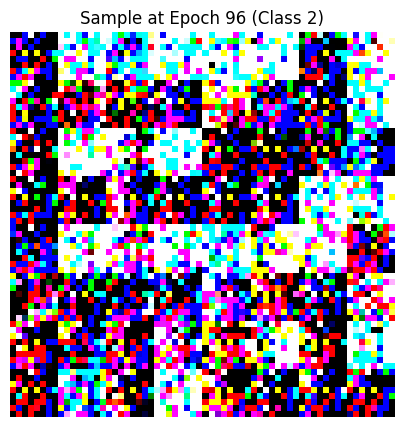

Epoch 97/100: 100%|██████████| 225/225 [00:15<00:00, 14.98it/s, train_loss=0.204]


Epoch 97 Validation Loss: 0.1749
Epoch 97: Generating sample image...


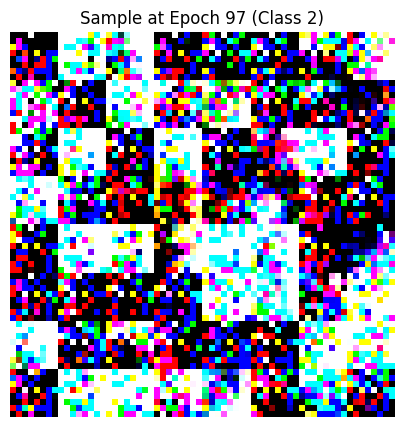

Epoch 98/100: 100%|██████████| 225/225 [00:15<00:00, 14.67it/s, train_loss=0.262] 


Epoch 98 Validation Loss: 0.2678
Epoch 98: Generating sample image...


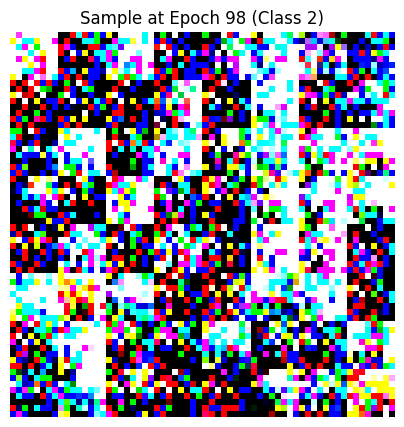

Epoch 99/100: 100%|██████████| 225/225 [00:15<00:00, 14.70it/s, train_loss=0.128] 


Epoch 99 Validation Loss: 0.1285
Epoch 99: Generating sample image...


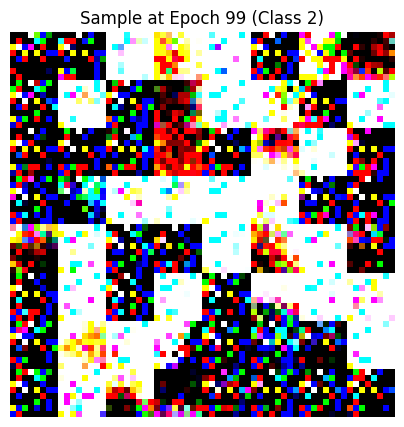

Epoch 100/100: 100%|██████████| 225/225 [00:15<00:00, 14.96it/s, train_loss=0.0973]


Epoch 100 Validation Loss: 0.0977
Epoch 100: Generating sample image...


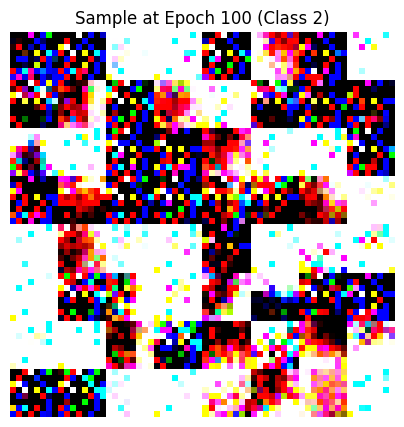

Training finished.


In [ ]:


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import os
import math
import json
from tqdm import tqdm
import random
# Added imports
import requests
from io import BytesIO
from itertools import islice
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional


import torch._dynamo
torch._dynamo.config.suppress_errors = True

bruh = 0

def download_image(url: str) -> Optional[Image.Image]:
    """Download image from URL and return PIL Image object."""
    try:
        response = requests.get(url, timeout=10, headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
        if response.status_code == 200:
            return Image.open(BytesIO(response.content)).convert('RGB')
    except Exception:
        pass
    return None

class CustomImageDataset(Dataset):
    """
    A dataset that loads and filters images from a Hugging Face dataset.
    It uses real images but generates random class labels to match the model's expected input.
    """
    def __init__(self, dataset_name="conceptual_captions", num_samples=1000, image_size=256, num_classes=10):
        self.image_size = image_size
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
        ])
        
        self.data = self._load_and_filter_data(dataset_name, num_samples)
        if not self.data:
            raise RuntimeError(f"Could not load any valid data from '{dataset_name}'. Please check the dataset or your connection.")

    def _load_and_filter_data(self, dataset_name, num_samples_to_find):
        print(f"Loading dataset '{dataset_name}' in streaming mode...")
        try:
            dataset_stream = load_dataset(dataset_name, split="train", streaming=True, trust_remote_code=True)
        except Exception as e:
            print(f"Failed to load dataset '{dataset_name}': {e}")
            return []

        print(f"Filtering for {num_samples_to_find} valid image samples...")
        filtered_images = []
        
        max_to_check = num_samples_to_find * 10
        
        pbar = tqdm(islice(dataset_stream, max_to_check), total=num_samples_to_find, desc="Filtering samples")

        for sample in pbar:
            if len(filtered_images) >= num_samples_to_find:
                break

            url = sample.get('image_url') or sample.get('url') # Support different key names
            caption = sample.get('caption') or sample.get('text')

            if url and isinstance(url, str) and caption and isinstance(caption, str):
                img = download_image(url)
                if img:
                    filtered_images.append(img)
                    pbar.update(1)
        
        pbar.close()
        if len(filtered_images) < num_samples_to_find:
            print(f"Warning: Could only find {len(filtered_images)} valid images out of the requested {num_samples_to_find}.")
        
        print(f"Successfully loaded and filtered {len(filtered_images)} images.")
        return filtered_images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        
        label = torch.randint(0, self.num_classes, (1,)).item()
        
        return self.transform(img), label


def get_beta_schedule(num_diffusion_timesteps):
    """
    Returns a linear beta schedule.
    """
    betas = torch.linspace(0.0001, 0.02, num_diffusion_timesteps)
    return betas

def q_sample(x_start, t, alphas_cumprod, noise=None):
    """
    Forward diffusion process: add noise to an image.
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t])[:, None, None, None]
    
    noisy_image = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy_image


@torch.no_grad()
def p_sample_loop(model, shape, num_timesteps, alphas, betas, alphas_cumprod, device, class_label=0):
    """
    Reverse diffusion process: generate an image from noise.
    """
    img = torch.randn(shape, device=device)
    
    labels = torch.tensor([class_label] * shape[0], device=device)

    for i in tqdm(reversed(range(num_timesteps)), desc="Sampling", total=num_timesteps, leave=False):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        
        # The model might be wrapped in DataParallel or torch.compile
        model_to_run = model.module if isinstance(model, (nn.DataParallel, nn.parallel.DistributedDataParallel)) else model
        predicted_noise = model_to_run(img, t, labels)
        
        alpha_t = alphas[t][:, None, None, None]
        alpha_cumprod_t = alphas_cumprod[t][:, None, None, None]
        beta_t = betas[t][:, None, None, None]
        
        if i > 0:
            noise = torch.randn_like(img)
        else:
            noise = torch.zeros_like(img)
            
        img = 1 / torch.sqrt(alpha_t) * (img - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
        
    return img

def show_sample_image(tensor, title=""):
    """
    Display a tensor as an image using matplotlib.
    Assumes the script is run in a notebook environment where plt.show() is non-blocking.
    """
    # Denormalize from [-1, 1] to [0, 1]
    tensor = (tensor + 1) / 2
    tensor.clamp_(0, 1)
    
    # (C, H, W) -> (H, W, C)
    img_np = tensor.cpu().numpy().transpose(1, 2, 0)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')
    # plt.savefig(f"images/{bruh}")#savefig
    plt.show()

@torch.no_grad()
def validate(model, dataloader, num_diffusion_timesteps, alphas_cumprod, criterion, device):
    """
    Validation loop. Runs entirely on the specified device.
    """
    model.eval()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Validating", leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        t = torch.randint(0, num_diffusion_timesteps, (images.shape[0],), device=device).long()
        noise = torch.randn_like(images)
        noisy_images = q_sample(images, t, alphas_cumprod, noise)
        
        predicted_noise = model(noisy_images, t, labels)
        loss = criterion(predicted_noise, noise)
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    model.train()
    return total_loss / len(dataloader)


def main():
    config = DiTConfig(
        image_size=64,
        patch_size=8,
        in_channels=3,
        n_embd=512,
        n_head=8,
        n_layer=6,
        dropout=0.1
           
    )
    
    epochs = 100 
    batch_size = 32 #32
    learning_rate = 4e-3#1e-4
    num_classes = 10
    num_diffusion_timesteps = 1000
    validation_split = 0.1 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print("Loading dataset from Hugging Face...")
    dataset = CustomImageDataset(
        num_samples=8000, 
        image_size=config.image_size, 
        num_classes=num_classes
    )
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    print(f"Dataset split: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    print(f"Initializing DiT model on {device}...")
    model = DiT(config, num_classes=num_classes)
    
    print("Compiling model with torch.compile()...")
    model = torch.compile(model)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel.")
        model = nn.DataParallel(model)
        
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    betas = get_beta_schedule(num_diffusion_timesteps).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    print("Starting training...")
    step = 0
    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            t = torch.randint(0, num_diffusion_timesteps, (images.shape[0],), device=device).long()
            noise = torch.randn_like(images)
            noisy_images = q_sample(images, t, alphas_cumprod, noise)
            
            optimizer.zero_grad(set_to_none=True)
            predicted_noise = model(noisy_images, t, labels)
            loss = criterion(predicted_noise, noise)
            
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix(train_loss=loss.item())
            step += 1

        val_loss = validate(model, val_dataloader, num_diffusion_timesteps, alphas_cumprod, criterion, device)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}")

        print(f"Epoch {epoch+1}: Generating sample image...")
        model.eval()
        sample_shape = (1, config.in_channels, config.image_size, config.image_size)
        sample = p_sample_loop(model, sample_shape, num_diffusion_timesteps, alphas, betas, alphas_cumprod, device, class_label=2)
        
        title = f"Sample at Epoch {epoch+1} (Class 2)"
        show_sample_image(sample[0].cpu(), title=title)

    print("Training finished.")

if __name__ == "__main__":
    main()

Note enough compute to even finish this model lol